## Setup and data read

In [1]:
# Imports and parameter setting
from pyspark.sql import SparkSession,  Row
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn import ensemble

import pandas as pd
import numpy as np
import cPickle as pickle

pd.set_option("display.max_columns", 100)

inputPath = '/home/jovyan/work/data/autot4.7.csv'

# Create a spark session
session = SparkSession \
    .builder \
    .appName("Car data") \
    .config('spark.driver.memory', '5G') \
    .config('spark.executor.memory', '5G') \
    .getOrCreate()
    


In [2]:
# Read input data into a spark data frame
# remove . from column names
inDf = session.read \
    .format("org.apache.spark.csv") \
    .option("header", "true") \
    .option("delimiter", ";") \
    .option("mode", "DROPMALFORMED") \
    .csv(inputPath)
    
newColnames = [col.replace('.','_',5) for col in inDf.columns]
inDf = inDf.toDF(*newColnames)

In [3]:
inDf.printSchema()

root
 |-- ajoneuvoluokka: string (nullable = true)
 |-- ensirekisterointipvm: string (nullable = true)
 |-- ajoneuvoryhma: string (nullable = true)
 |-- ajoneuvonkaytto: string (nullable = true)
 |-- variantti: string (nullable = true)
 |-- versio: string (nullable = true)
 |-- kayttoonottopvm: string (nullable = true)
 |-- vari: string (nullable = true)
 |-- ovienLukumaara: string (nullable = true)
 |-- korityyppi: string (nullable = true)
 |-- ohjaamotyyppi: string (nullable = true)
 |-- istumapaikkojenLkm: string (nullable = true)
 |-- omamassa: string (nullable = true)
 |-- teknSuurSallKokmassa: string (nullable = true)
 |-- tieliikSuurSallKokmassa: string (nullable = true)
 |-- ajonKokPituus: string (nullable = true)
 |-- ajonLeveys: string (nullable = true)
 |-- ajonKorkeus: string (nullable = true)
 |-- kayttovoima: string (nullable = true)
 |-- iskutilavuus: string (nullable = true)
 |-- suurinNettoteho: string (nullable = true)
 |-- sylintereidenLkm: string (nullable = true)
 

In [4]:
inDf.first().asDict()

{'Co2': u'NA',
 'N_id': u'7',
 'ahdin': u'false',
 'ajonKokPituus': u'4600',
 'ajonKorkeus': u'NA',
 'ajonLeveys': u'1720',
 'ajoneuvoluokka': u'Henkil\xf6auto',
 'ajoneuvonkaytto': u'Yksityinen',
 'ajoneuvoryhma': u'NA',
 'alue': u'469',
 'data': u'4.7',
 'ensirekVuosi': u'1997',
 'ensirekisterointipvm': u'1997-01-10',
 'historia': u'1',
 'id': u'273638',
 'iskutilavuus': u'1780',
 'istumapaikkojenLkm': u'5',
 'jarnro': u'2',
 'kaupallinenNimi': u'PASSAT',
 'kayttoonotto': u'1997-01-10',
 'kayttoonottoVuosi': u'1997',
 'kayttoonotto_pvm_imputoitu': u'0',
 'kayttoonottopvm': u'1997-01-10',
 'kayttovoima': u'Bensiini',
 'korityyppi': u'Farmari (AC)',
 'kunta': u'286',
 'l_malli': u'PASSAT',
 'malli': u'PASSAT',
 'mallimerkinta': u'5D PASSAT VARIANT 1.8 CL-351-C/263',
 'matkamittarilukema': u'355890',
 'max_date': u'2016-09-30',
 'merkki': u'VOLKSWAGEN',
 'merkki_l_malli': u'VOLKSWAGEN PASSAT',
 'ohjaamotyyppi': u'Umpiohjaamo',
 'omamassa': u'1320',
 'ovienLukumaara': u'5',
 'sahkohybrid

In [5]:
#Select a subset of columns and set their types 
carsDf = inDf.select(
    'ajoneuvoluokka',
    'ajoneuvonkaytto',
    'ajoneuvoryhma',
    'korityyppi',
    'ohjaamotyyppi',
    'kayttovoima',
    'istumapaikkojenLkm',
    'sylintereidenLkm',
    'vaihteisto',
    'alue',
    'kunta',
    'merkki',
    'malli',
    'merkki_l_malli',
    'kayttoonotto_pvm_imputoitu',
    inDf['omamassa'].cast("int"),
    inDf['iskutilavuus'].cast("int"),
    inDf['suurinNettoteho'].cast("int"),
    inDf['matkamittarilukema'].cast("int"),
    inDf['kayttoonottoVuosi'].cast("int"),
    inDf['ensirekVuosi'].cast("int"),
    inDf['ensirekisterointipvm'].cast("timestamp"),
    inDf['kayttoonottopvm'].cast("timestamp"),
    inDf['max_date'].cast("timestamp"),
    inDf['kayttoonotto'].cast("timestamp")
)
# List of variables by types strings are called 'factors'
factorVars = [
    'ajoneuvoluokka',
    'ajoneuvonkaytto',
    'ajoneuvoryhma',
    'korityyppi',
    'ohjaamotyyppi',
    'kayttovoima',
    'istumapaikkojenLkm',
    'sylintereidenLkm',
    'vaihteisto',
    'alue',
    'kunta',
    'merkki',
    'malli',
    'merkki_l_malli',
    'kayttoonotto_pvm_imputoitu'
]
numericVars = [
    'omamassa',
    'iskutilavuus',
    'suurinNettoteho',
    'matkamittarilukema',
    'kayttoonottoVuosi',
    'ensirekVuosi'
]
dateVars = [
    'ensirekisterointipvm',
    'kayttoonottopvm',
    'max_date',
    'kayttoonotto'
]


In [6]:
carsDf.printSchema()

root
 |-- ajoneuvoluokka: string (nullable = true)
 |-- ajoneuvonkaytto: string (nullable = true)
 |-- ajoneuvoryhma: string (nullable = true)
 |-- korityyppi: string (nullable = true)
 |-- ohjaamotyyppi: string (nullable = true)
 |-- kayttovoima: string (nullable = true)
 |-- istumapaikkojenLkm: string (nullable = true)
 |-- sylintereidenLkm: string (nullable = true)
 |-- vaihteisto: string (nullable = true)
 |-- alue: string (nullable = true)
 |-- kunta: string (nullable = true)
 |-- merkki: string (nullable = true)
 |-- malli: string (nullable = true)
 |-- merkki_l_malli: string (nullable = true)
 |-- kayttoonotto_pvm_imputoitu: string (nullable = true)
 |-- omamassa: integer (nullable = true)
 |-- iskutilavuus: integer (nullable = true)
 |-- suurinNettoteho: integer (nullable = true)
 |-- matkamittarilukema: integer (nullable = true)
 |-- kayttoonottoVuosi: integer (nullable = true)
 |-- ensirekVuosi: integer (nullable = true)
 |-- ensirekisterointipvm: timestamp (nullable = true)


In [7]:
carsDf.first().asDict()

{'ajoneuvoluokka': u'Henkil\xf6auto',
 'ajoneuvonkaytto': u'Yksityinen',
 'ajoneuvoryhma': u'NA',
 'alue': u'469',
 'ensirekVuosi': 1997,
 'ensirekisterointipvm': datetime.datetime(1997, 1, 10, 0, 0),
 'iskutilavuus': 1780,
 'istumapaikkojenLkm': u'5',
 'kayttoonotto': datetime.datetime(1997, 1, 10, 0, 0),
 'kayttoonottoVuosi': 1997,
 'kayttoonotto_pvm_imputoitu': u'0',
 'kayttoonottopvm': datetime.datetime(1997, 1, 10, 0, 0),
 'kayttovoima': u'Bensiini',
 'korityyppi': u'Farmari (AC)',
 'kunta': u'286',
 'malli': u'PASSAT',
 'matkamittarilukema': 355890,
 'max_date': datetime.datetime(2016, 9, 30, 0, 0),
 'merkki': u'VOLKSWAGEN',
 'merkki_l_malli': u'VOLKSWAGEN PASSAT',
 'ohjaamotyyppi': u'Umpiohjaamo',
 'omamassa': 1320,
 'suurinNettoteho': 66,
 'sylintereidenLkm': u'4',
 'vaihteisto': None}

In [8]:
# We want to predict mileage (matkamittarilukema), filter to only possible values
# Persist this set to memory
carsDf = carsDf.filter(carsDf.matkamittarilukema.between(1, 1e6)).cache()

In [9]:
# Calculate a new columns from originals.
carsDf = carsDf.withColumn(
    'usageDays', 
    (carsDf['max_date'].cast('long')-carsDf['kayttoonottopvm'].cast('long'))/(24.0 * 3600.0)
)
numericVars.append('usageDays')

carsDf = carsDf.withColumn(
    'mileagePerDay', 
    carsDf['matkamittarilukema'].cast('float')/carsDf['usageDays']
)
numericVars.append('mileagePerDay')

## Exploration

### pro-tip
write ? after a function or method and run cell to see its documentation
```python 
carsDf.sample?
```
    

In [10]:
# take a sample into pandas data frame for plotting and stats
sample = carsDf.sample(False, 0.005).toPandas()

### Print samples & stats

In [11]:
sample.head()

,ajoneuvoluokka,ajoneuvonkaytto,ajoneuvoryhma,korityyppi,ohjaamotyyppi,kayttovoima,istumapaikkojenLkm,sylintereidenLkm,vaihteisto,alue,kunta,merkki,malli,merkki_l_malli,kayttoonotto_pvm_imputoitu,omamassa,iskutilavuus,suurinNettoteho,matkamittarilukema,kayttoonottoVuosi,ensirekVuosi,ensirekisterointipvm,kayttoonottopvm,max_date,kayttoonotto,usageDays,mileagePerDay
0,Henkilöauto,Yksityinen,NA,Viistoperä (AB),NA,Bensiini,5,4,None,196,172,FORD,FOCUS,FORD FOCUS,0,1239.0,1590.0,85.0,169923,2005,2005.0,2005-08-31,2005-08-31,2016-09-30,2005-08-31,4048.0,41.977026
1,Henkilöauto,Yksityinen,NA,NA,Umpiohjaamo,Bensiini,5,4,None,909,564,PEUGEOT,106,PEUGEOT 106,0,850.0,1120.0,44.0,285593,1995,1995.0,1995-05-31,1995-05-31,2016-09-30,1995-05-31,7793.0,36.647376
2,Henkilöauto,Yksityinen,NA,Farmari (AC),NA,Bensiini,5,4,None,771,593,FORD,MAVERICK,FORD MAVERICK,0,1595.0,2260.0,110.0,193241,2005,2005.0,2005-09-19,2005-09-19,2016-09-30,2005-09-19,4029.0,47.962522
3,Henkilöauto,Yksityinen,NA,Farmari (AC),NA,Bensiini,5,4,None,678,272,RENAULT,LAGUNA,RENAULT LAGUNA,0,1380.0,1590.0,82.0,166665,2006,2006.0,2006-04-19,2006-04-19,2016-09-30,2006-04-19,3817.0,43.663872
4,Henkilöauto,Yksityinen,NA,Viistoperä (AB),NA,Bensiini,5,4,None,71,611,ALFA ROMEO,147,ALFA ROMEO 147,0,1325.0,1970.0,110.0,147732,2004,2004.0,2004-11-12,2004-11-12,2016-09-30,2004-11-12,4340.0,34.039631


In [12]:
sample.kayttoonotto.head()

0   2005-08-31
1   1995-05-31
2   2005-09-19
3   2006-04-19
4   2004-11-12
Name: kayttoonotto, dtype: datetime64[ns]

In [13]:
sample.describe(include=[np.number])

,omamassa,iskutilavuus,suurinNettoteho,matkamittarilukema,kayttoonottoVuosi,ensirekVuosi,usageDays,mileagePerDay
count,11252.000000,11252.000000,10929.000000,11256.000000,11256.000000,11203.000000,11256.000000,11256.000000
mean,1414.887931,1858.460718,92.712691,183449.830579,2003.878198,2004.039811,4535.410714,44.491129
std,336.883927,577.516660,31.403032,110323.430902,6.828066,6.418791,2490.860772,27.581452
min,500.000000,480.000000,0.000000,1.000000,1929.000000,1929.000000,42.000000,0.000981
25%,1225.000000,1580.000000,74.000000,99169.000000,2000.000000,2000.000000,2824.500000,28.737182
50%,1375.000000,1780.000000,85.000000,169888.000000,2005.000000,2005.000000,4194.000000,40.377024
75%,1556.000000,1990.000000,106.000000,247238.250000,2009.000000,2009.000000,5867.750000,55.022642
max,12800.000000,11020.000000,408.000000,999999.000000,2016.000000,2016.000000,31792.000000,871.957274


In [14]:
sample.describe(include=[object])

,ajoneuvoluokka,ajoneuvonkaytto,ajoneuvoryhma,korityyppi,ohjaamotyyppi,kayttovoima,istumapaikkojenLkm,sylintereidenLkm,vaihteisto,alue,kunta,merkki,malli,merkki_l_malli,kayttoonotto_pvm_imputoitu
count,11256,11256,11256,11256,11256,11256,11256,11256,4008,11256,11256,11256,11256,11256,11256
unique,2,5,11,13,4,6,9,9,6,762,299,115,732,720,2
top,Henkilöauto,Yksityinen,NA,Farmari (AC),NA,Bensiini,5,4,Käsivalintainen,9,091,TOYOTA,COROLLA,TOYOTA COROLLA,0
freq,10973,11028,10937,3086,8876,8191,10081,8848,2415,151,801,1483,494,494,10991


In [15]:
sample.describe(include=[np.datetime64])

,ensirekisterointipvm,kayttoonottopvm,max_date,kayttoonotto
count,11203,11256,11256,10991
unique,4576,4491,1,4451
top,2012-03-30 00:00:00,1989-06-30 00:00:00,2016-09-30 00:00:00,2012-03-30 00:00:00
freq,21,45,11256,19
first,1975-08-06 00:00:00,1929-09-15 00:00:00,2016-09-30 00:00:00,1929-09-15 00:00:00
last,2016-09-30 00:00:00,2016-08-19 00:00:00,2016-09-30 00:00:00,2016-08-19 00:00:00


In [16]:
sample.groupby('ajoneuvonkaytto')['mileagePerDay'].agg([np.median, np.mean, np.std])

,median,mean,std
ajoneuvonkaytto,,,
Kouluajoneuvo,28.745728,30.332725,31.271905
Luvanvarainen,150.014191,176.306699,85.649677
Myyntivarasto,48.523873,52.161409,27.728275
Vuokraus,30.769359,36.976628,38.030722
Yksityinen,40.177139,43.806760,25.549672


### Some plots

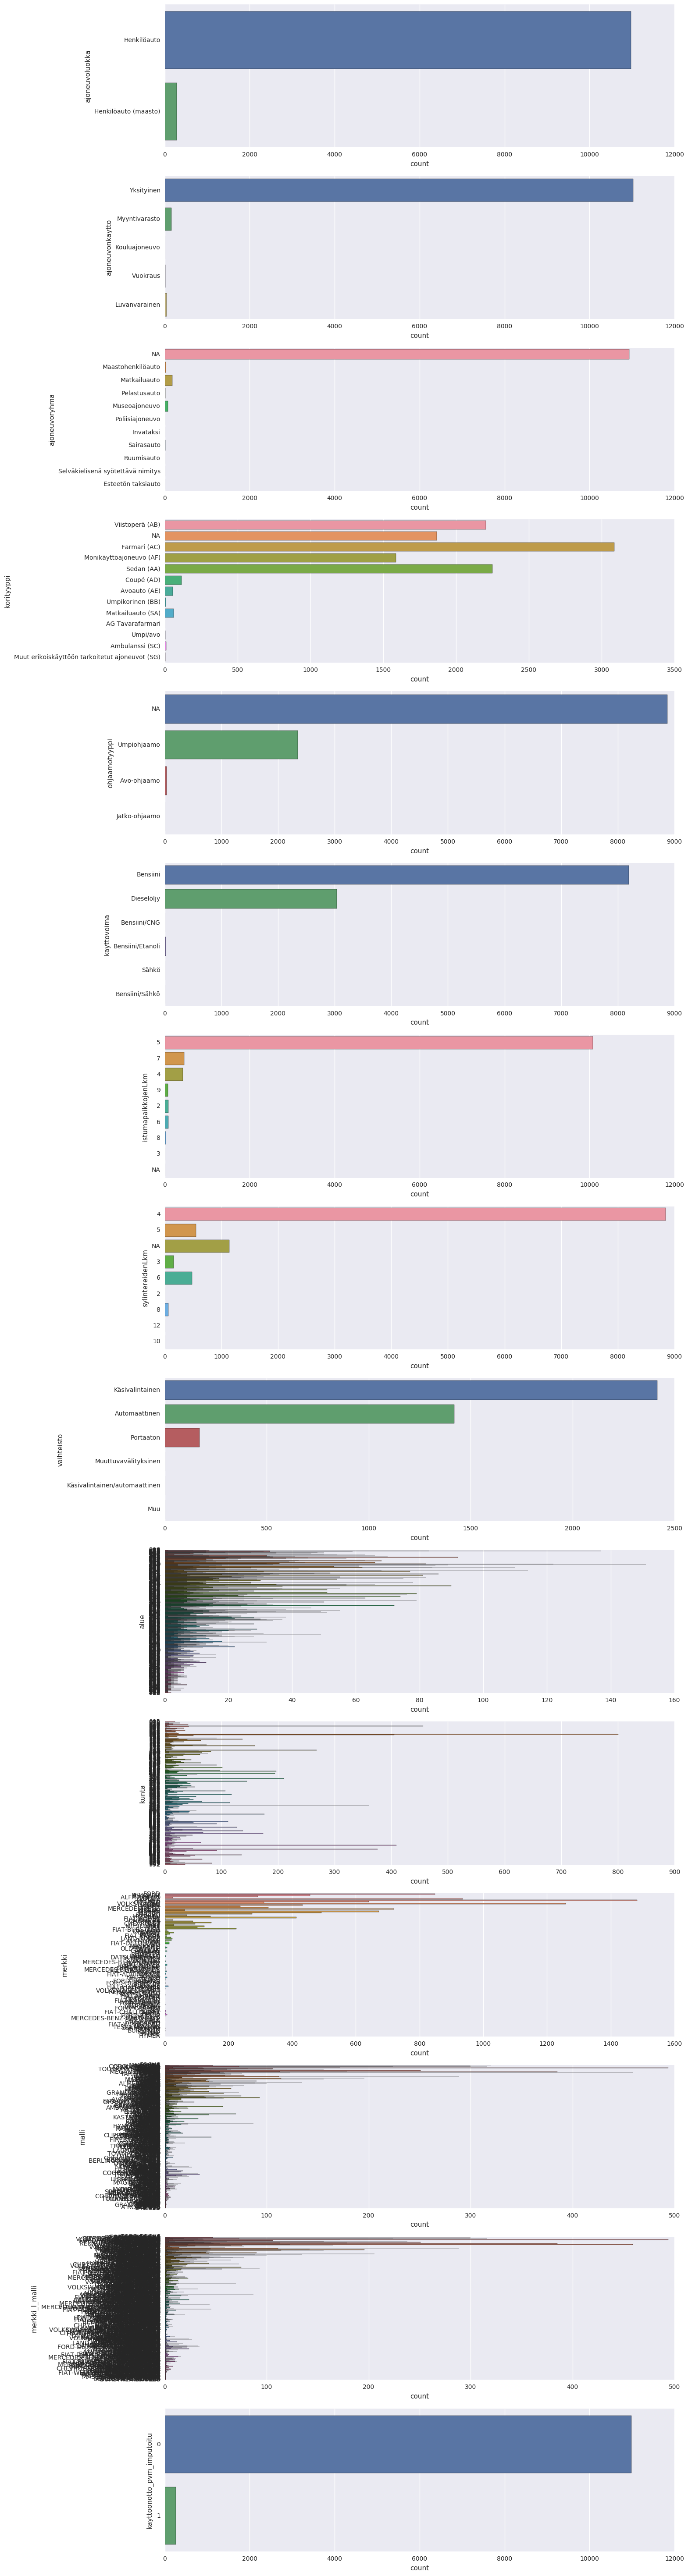

In [17]:
fig, axes = plt.subplots(len(factorVars), figsize=(15,len(factorVars)*5))
for i, c in enumerate(factorVars):
    sns.countplot(y=c, data=sample, ax=axes[i])
    #plt.show()
    #sample[c].value_counts().plot(ax=axes,kind='bar', alpha=0.7)
    #plt.suptitle(c)

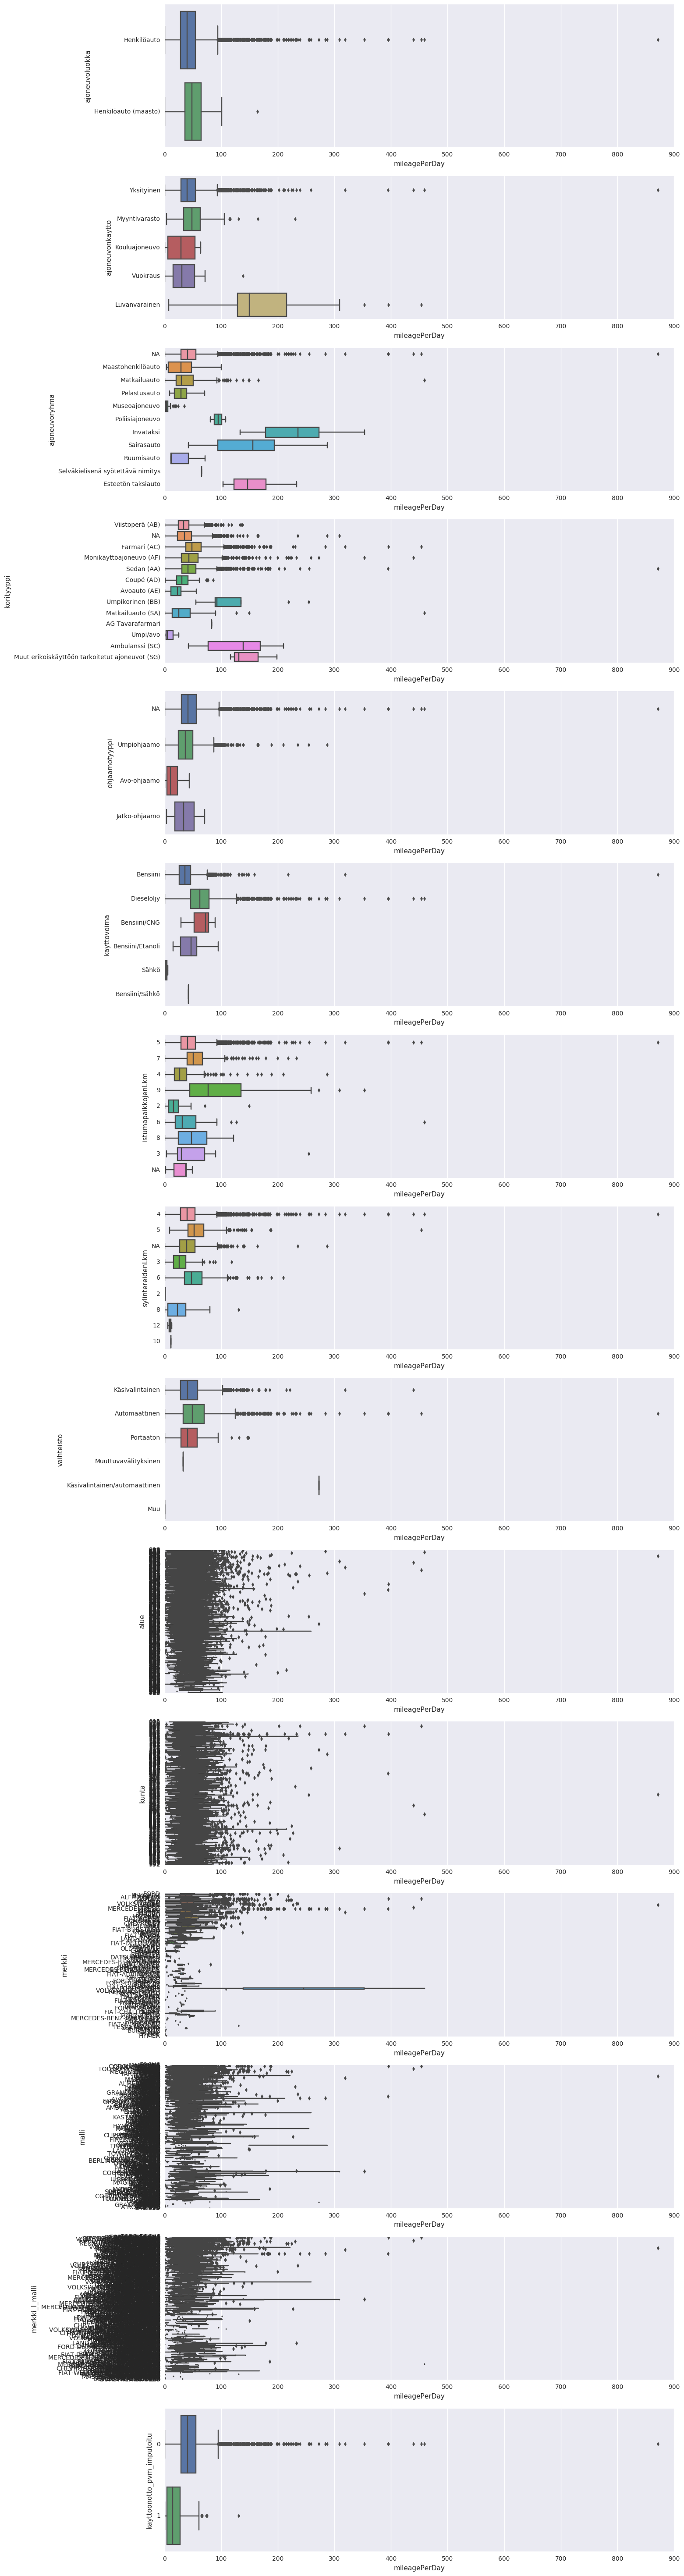

In [18]:
fig, axes = plt.subplots(len(factorVars), figsize=(15,len(factorVars)*5))
for i, c in enumerate(factorVars):
    sns.boxplot(y=c, x='mileagePerDay', orient='h', data=sample, ax=axes[i])


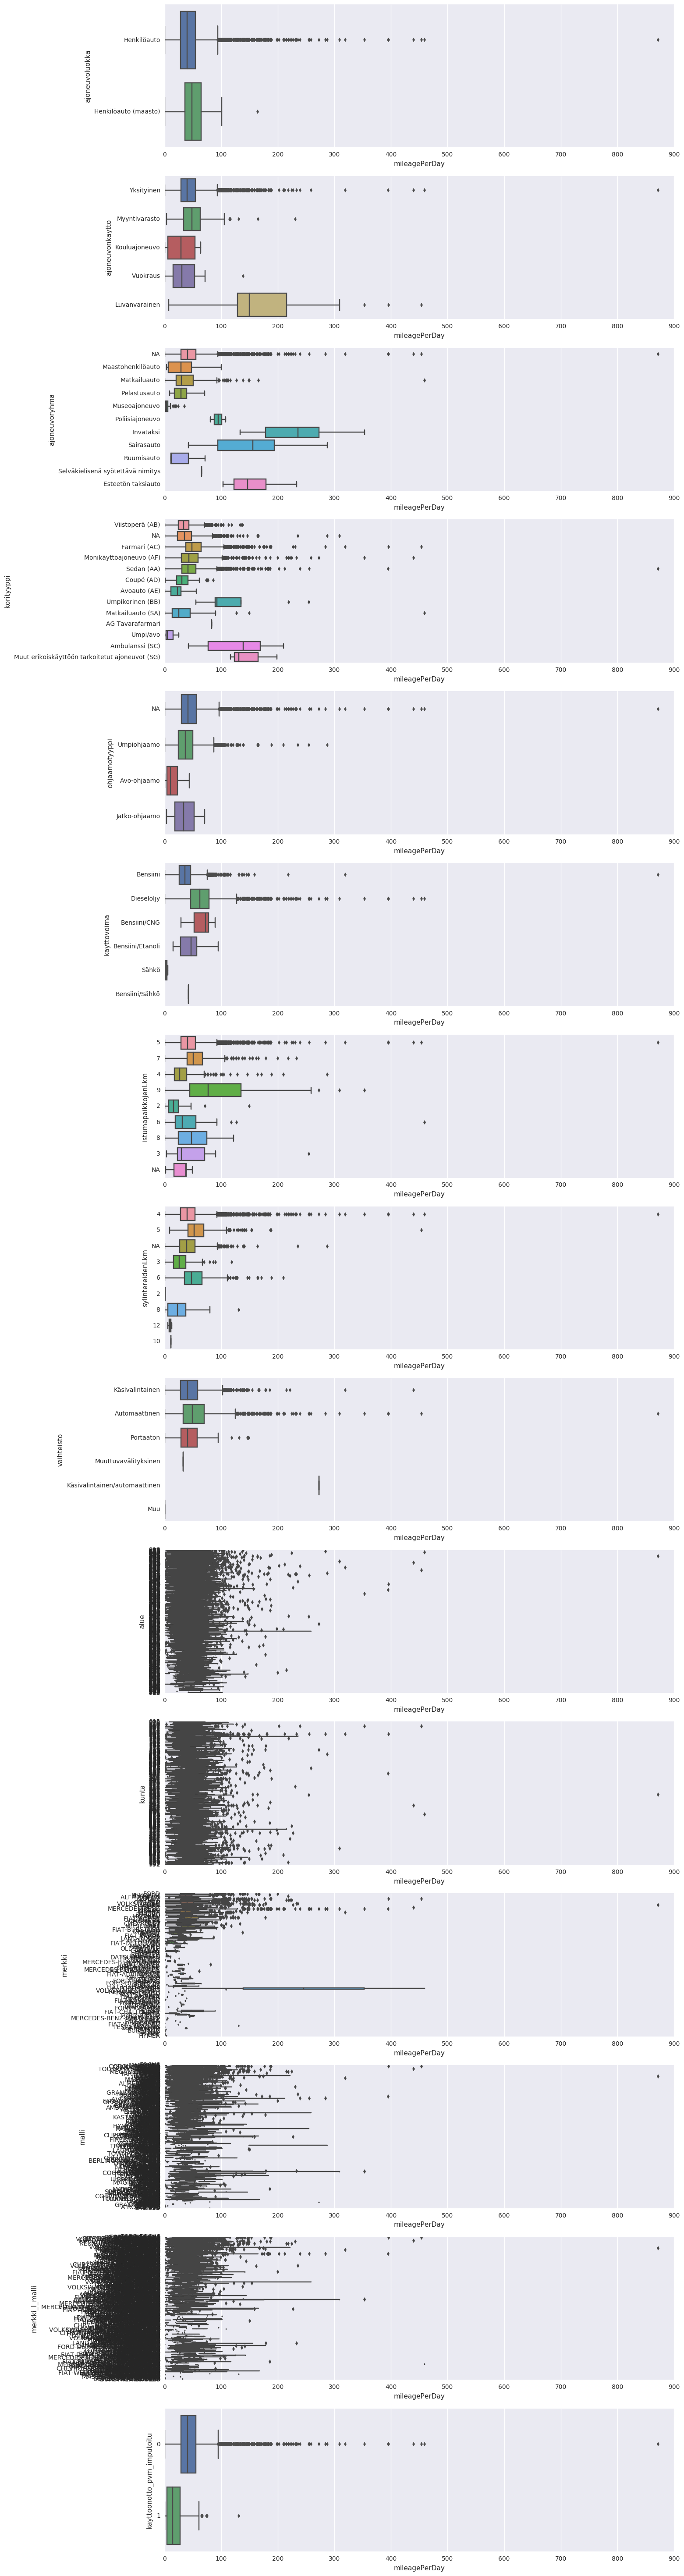

In [19]:
fig, axes = plt.subplots(len(factorVars), figsize=(15,len(factorVars)*5))
for i, c in enumerate(factorVars):
    sns.boxplot(y=c, x='mileagePerDay', orient='h', data=sample, ax=axes[i])


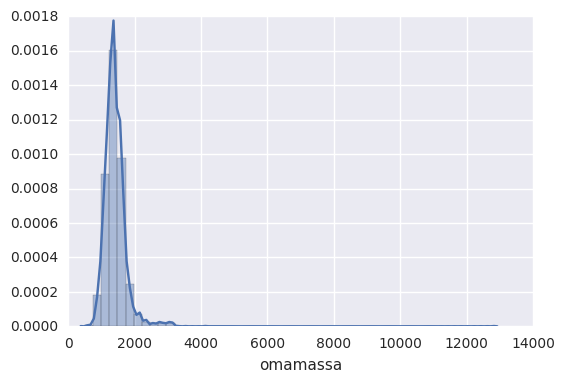

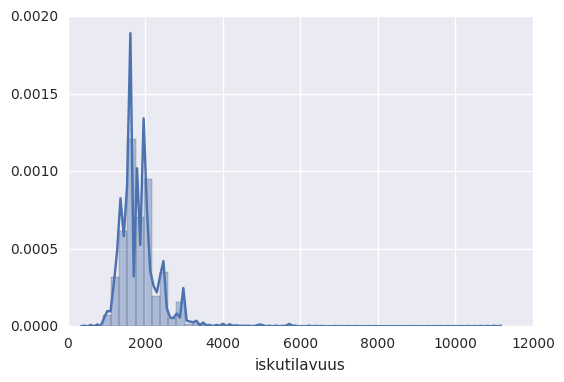

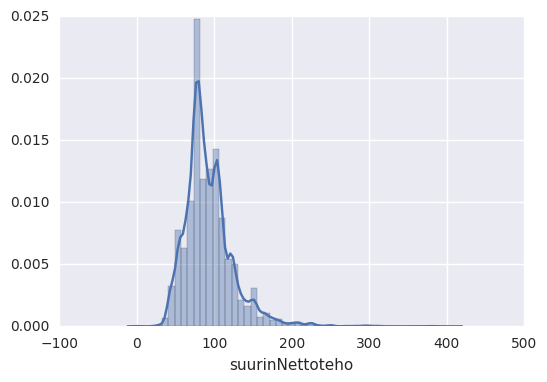

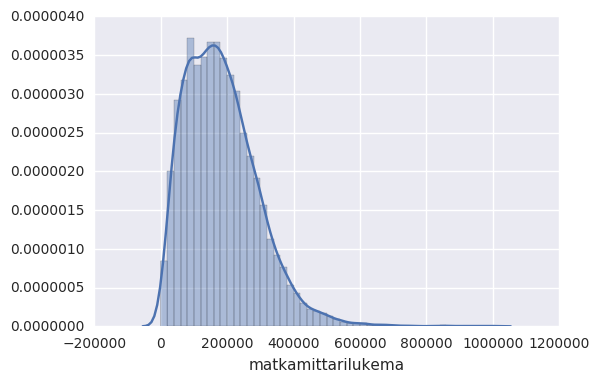

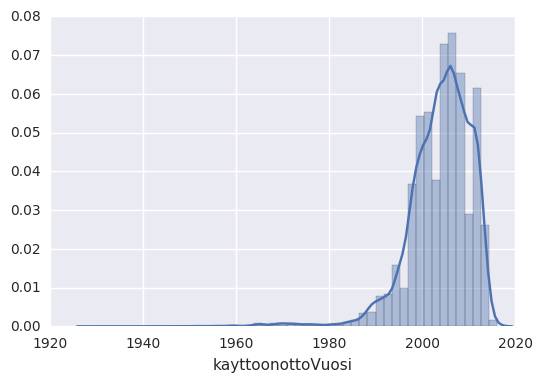

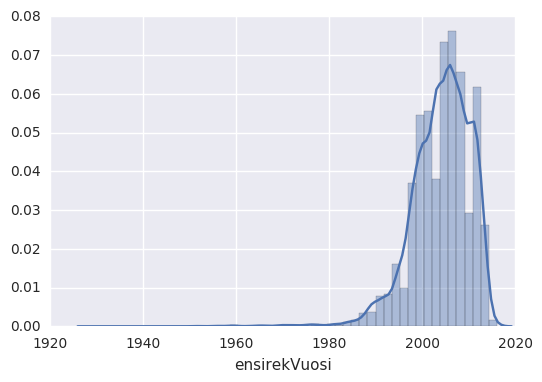

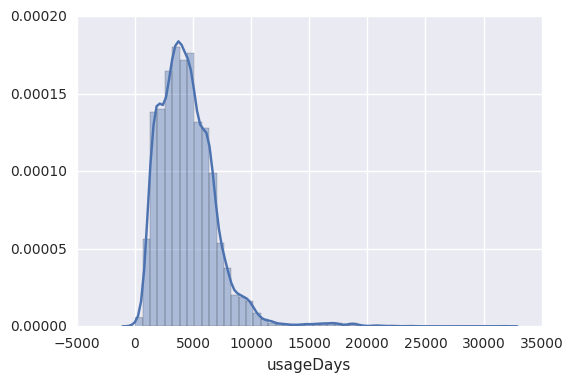

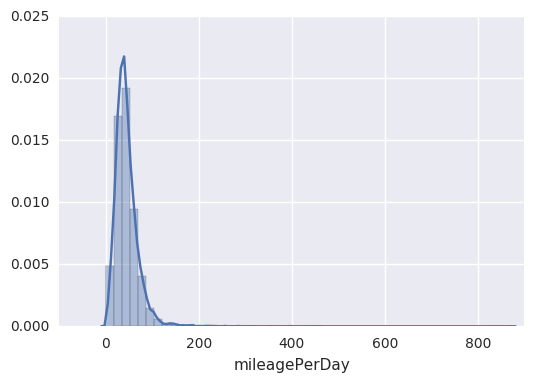

In [20]:
for c in numericVars:
    fig, axes = plt.subplots()
    sns.distplot(sample[c].dropna())
    plt.show()

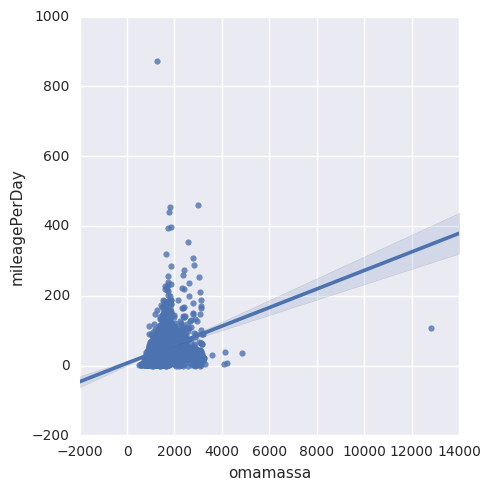

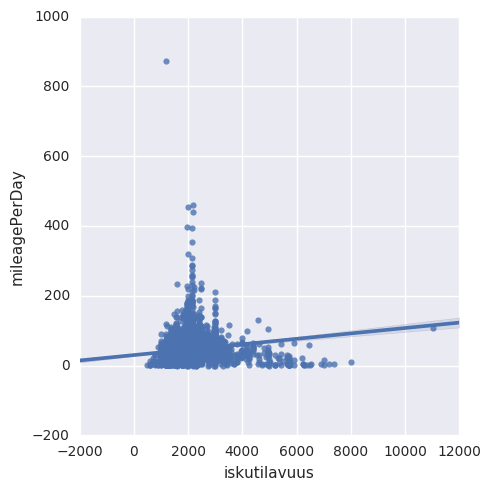

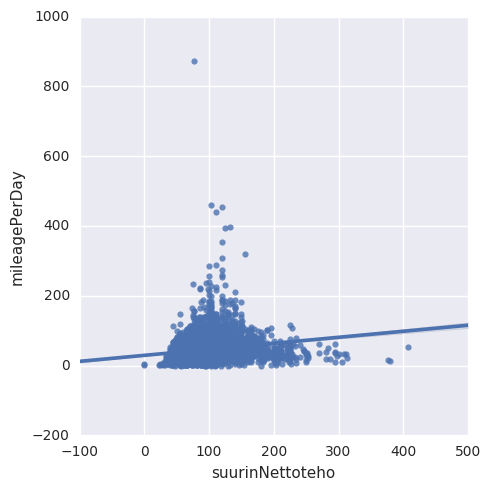

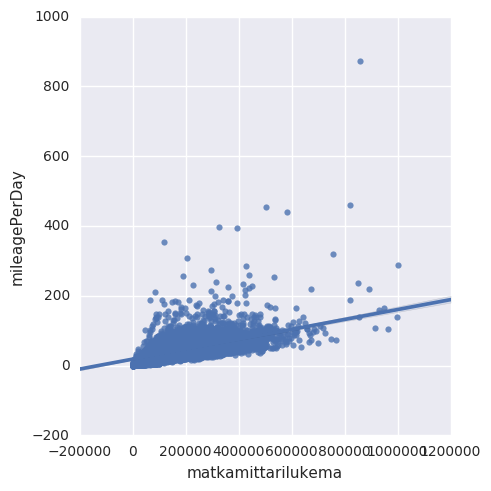

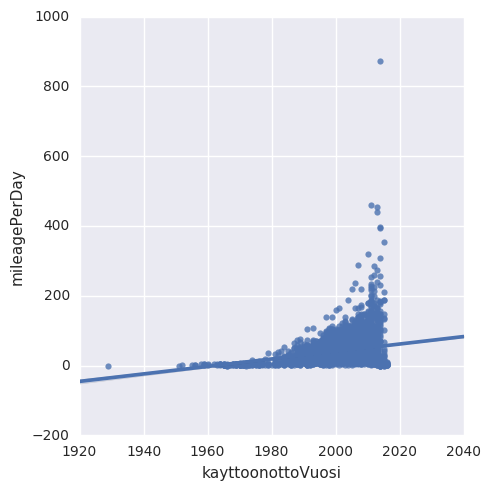

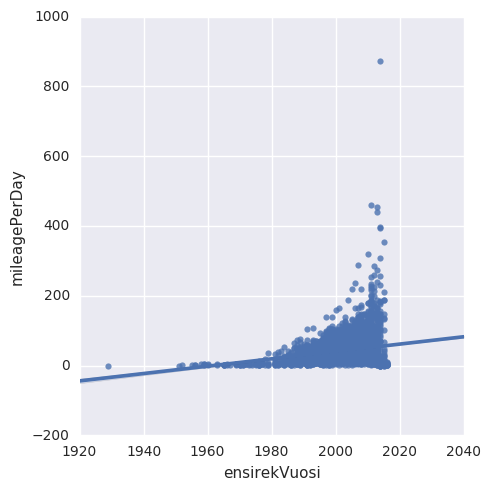

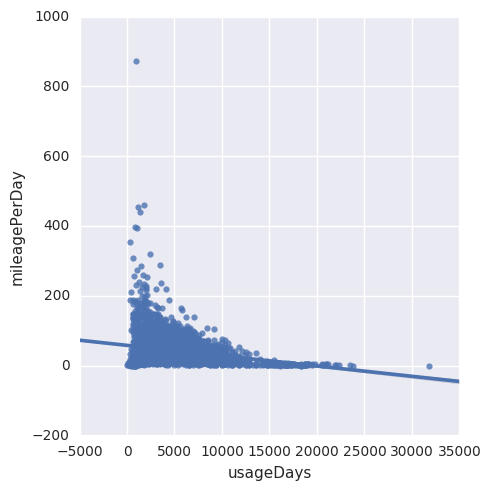

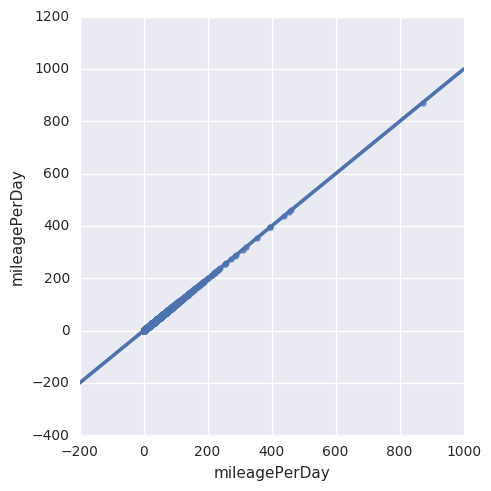

In [21]:
for c in numericVars:
    sns.lmplot(x=c, y='mileagePerDay', data=sample, robust=False)
    plt.show()


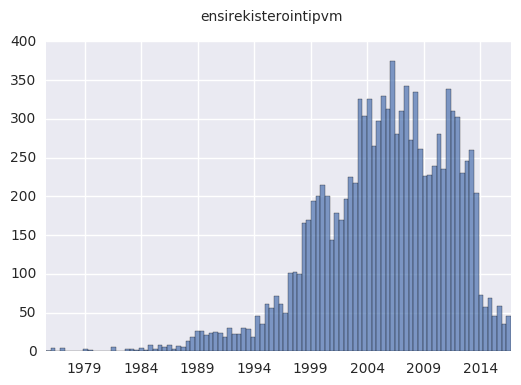

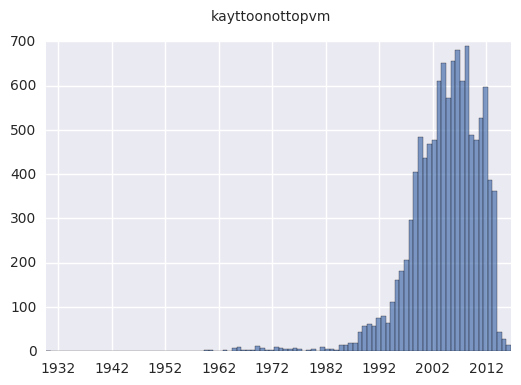

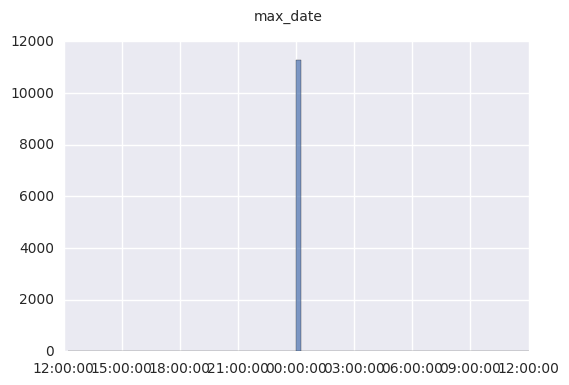

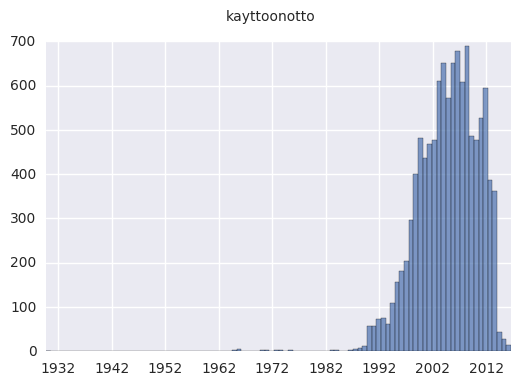

In [22]:
for c in dateVars:
    fig, axes = plt.subplots()
    sample[c].hist(bins=100, alpha=0.7)
    plt.suptitle(c)

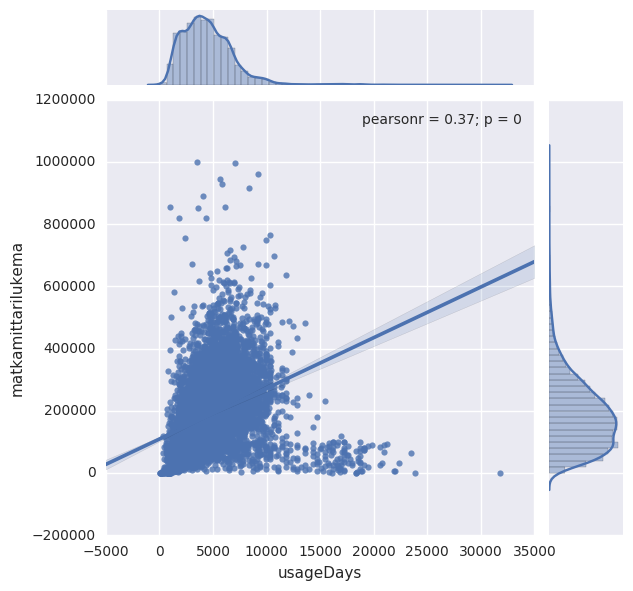

In [23]:
sns.jointplot(x='usageDays', y='matkamittarilukema', data=sample, kind='reg')